In [1]:
from __future__ import print_function, division
import argparse
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import datetime
import os
import copy
import sys
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RunningAverage, RootMeanSquaredError
from ignite.handlers import ModelCheckpoint, EarlyStopping
from utils.datatools import PlanktonRegressionDataset

sys.path.append('../finetune_copepod')
from finetune_model import train_model

Define the image transforms

In [2]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        #transforms.RandomAffine(degrees=0,scale=(0.5, 2), shear=(-5, 5)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Define file paths, datasets, and loaders.

In [3]:
vocpath = '/home/eorenstein/VOCCopepodEgg'
imgset = 'DeepReg-EggOnly-150321'

# training data
train_dataset = PlanktonRegressionDataset(root=vocpath,
                                          img_set=f'{imgset}/egg_train.txt',
                                          transform=data_transforms['train'],
                                         )
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                           shuffle=True, num_workers=4)

# validation data
val_dataset = PlanktonRegressionDataset(root=vocpath,
                                        img_set=f'{imgset}/egg_val.txt',
                                        transform=data_transforms['val'],
                                       )
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64,
                                         shuffle=True, num_workers=4)

Grab the model with the pretrained weights.

In [4]:
model = models.resnet18(pretrained=True)

Get the number of features at the input of the final fully connected layer.

In [5]:
num_ftrs = model.fc.in_features
print(num_ftrs)

512


Reset the final fully connected layer to give a single output.

In [6]:
model.fc = nn.Linear(num_ftrs, 1)

# make sure the model will accept float inputs
model = model.float()

Find the gpu and send the model there.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = model.to(device)

Define the loss function and the optimizer. 

- Loss: Start with [Mean Squared Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). Per [Lathuiliere et al., 2020](https://arxiv.org/abs/1803.08450), also worth experimenting with [Mean Absolute Error](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss) and Huber loss.
- Optimizer: Lathuiliere et al., 2020 found that Adam optimzer most worked best with ResNet backbones.

In [8]:
criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Use Ignite to instatiate a training and validation cycle

In [9]:
# creating trainer,evaluator
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
metrics = {
    'RMSE':RootMeanSquaredError(),
    'MSELoss':Loss(criterion),
}

train_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
val_evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)

training_history = {'RMSE':[],'loss':[]}
validation_history = {'RMSE':[],'loss':[]}
last_epoch = []

Keep a running average of the loss for tracking.

In [10]:
RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

Define an early stopping condition. This stops the training if the loss does not decrease after 10 epochs

In [11]:
def score_function(engine):
    val_loss = engine.state.metrics['MSELoss']
    return -val_loss

handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
val_evaluator.add_event_handler(Events.COMPLETED, handler)

Login functions to be evaluated at the end of each epoch.

In [12]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(trainer):
    train_evaluator.run(train_loader)
    metrics = train_evaluator.state.metrics
    rmse = metrics['RMSE']
    loss = metrics['MSELoss']
    last_epoch.append(0)
    training_history['RMSE'].append(rmse)
    training_history['loss'].append(loss)
    print("Training Results - Epoch: {}  RMSE: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, rmse, loss))

def log_validation_results(trainer):
    val_evaluator.run(val_loader)
    metrics = val_evaluator.state.metrics
    rmse = metrics['RMSE']
    loss = metrics['MSELoss']
    validation_history['RMSE'].append(rmse)
    validation_history['loss'].append(loss)
    print("Validation Results - Epoch: {}  RMSE: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, rmse, loss))
    
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_validation_results)

Train the network for a few epochs.

In [13]:
trainer.run(train_loader, max_epochs=20)

Training Results - Epoch: 1  RMSE: 0.41 Avg loss: 0.17
Validation Results - Epoch: 1  RMSE: 0.43 Avg loss: 0.18
Training Results - Epoch: 2  RMSE: 0.32 Avg loss: 0.10
Validation Results - Epoch: 2  RMSE: 0.35 Avg loss: 0.12
Training Results - Epoch: 3  RMSE: 0.24 Avg loss: 0.06
Validation Results - Epoch: 3  RMSE: 0.28 Avg loss: 0.08
Training Results - Epoch: 4  RMSE: 0.18 Avg loss: 0.03
Validation Results - Epoch: 4  RMSE: 0.24 Avg loss: 0.06
Training Results - Epoch: 5  RMSE: 0.18 Avg loss: 0.03
Validation Results - Epoch: 5  RMSE: 0.23 Avg loss: 0.05
Training Results - Epoch: 6  RMSE: 0.16 Avg loss: 0.03
Validation Results - Epoch: 6  RMSE: 0.23 Avg loss: 0.05
Training Results - Epoch: 7  RMSE: 0.24 Avg loss: 0.06
Validation Results - Epoch: 7  RMSE: 0.29 Avg loss: 0.09
Training Results - Epoch: 8  RMSE: 0.16 Avg loss: 0.03
Validation Results - Epoch: 8  RMSE: 0.25 Avg loss: 0.06
Training Results - Epoch: 9  RMSE: 0.20 Avg loss: 0.04
Validation Results - Epoch: 9  RMSE: 0.24 Avg los

2021-03-16 14:54:10,128 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


Validation Results - Epoch: 20  RMSE: 0.22 Avg loss: 0.05


State:
	iteration: 420
	epoch: 20
	epoch_length: 21
	max_epochs: 20
	output: 0.017718879505991936
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

In [27]:
model.eval()
preds = []
gt = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        preds.extend(outputs.flatten().tolist())
        gt.extend(labels.flatten().tolist())

(0.0, 1.5)

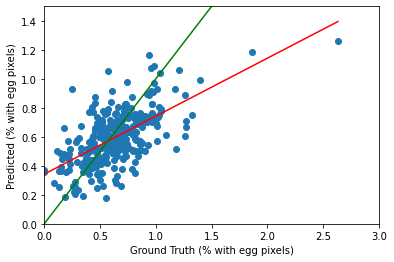

In [55]:
plt.scatter(gt, preds)
plt.plot(np.unique(gt), np.poly1d(np.polyfit(gt, preds, 1))(np.unique(gt)), color='r')
plt.plot(np.arange(0,3,0.01), np.arange(0,3,0.01), color='g')
plt.xlabel('Ground Truth (% with egg pixels)')
plt.ylabel('Predicted (% with egg pixels)')
plt.xlim([0, 3])
plt.ylim([0, 1.5])

In [61]:
coeffs = np.polyfit(gt, preds, 1)

# r-squared
p = np.poly1d(coeffs)

yhat = p(gt)                         # or [p(z) for z in x]
ybar = np.sum(preds)/len(preds)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((preds - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
ssreg / sstot

0.37919294096276585

(0.0, 1.2)

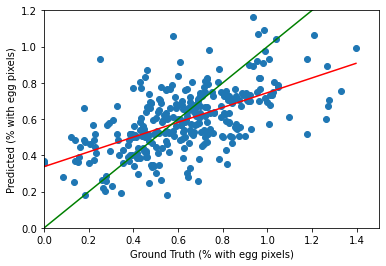

In [59]:
test_gt = np.array(gt)
test_pred = np.array(preds)
test_pred = test_pred[np.nonzero(test_gt<1.5)]
test_gt = test_gt[np.nonzero(test_gt<1.5)]

plt.scatter(test_gt, test_pred)
plt.plot(np.unique(test_gt), 
         np.poly1d(np.polyfit(test_gt, test_pred, 1))(np.unique(test_gt)), color='r')
plt.plot(np.arange(0,3,0.01), np.arange(0,3,0.01), color='g')
plt.xlabel('Ground Truth (% with egg pixels)')
plt.ylabel('Predicted (% with egg pixels)')
plt.xlim([0, 1.5])
plt.ylim([0, 1.2])

In [50]:
coeffs = np.polyfit(test_gt, test_pred, 1)

# r-squared
p = np.poly1d(coeffs)

yhat = p(gt)                         # or [p(z) for z in x]
ybar = np.sum(test_pred)/len(test_pred)          # or sum(y)/len(y)
ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
sstot = np.sum((test_pred - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
ssreg / sstot

0.427299489877151

In [64]:
now = datetime.datetime.now()
now = now.strftime("%m%d%y-%H%M")
torch.save(model.state_dict(), 
           os.path.join('/home/eorenstein/python_code/deep-regression/outputs',
                        f'{now}_resnet18_mseloss_20epochs.pt'))